## Dry Beans

Data taken from http://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset

The data were collected by Murat Koklu and Ilker Ali Ozkan.

Several physical measurements of 7 different kinds of dry beans.

Can the beans be classified from the measurements.

Demonstration:
1. Multidimensional input and output
2. SoftMax model with many (>100) parameters
3. Categorical output
4. Bernoulli errordistribution

In [1]:
import numpy as numpy
import math

from astropy.io import ascii
from BayesicFitting import SoftMaxModel
from BayesicFitting import BernoulliErrorDistribution
from BayesicFitting import LaplacePrior

from BayesicFitting import ClassicProblem
from BayesicFitting import MultipleOutputProblem
from BayesicFitting import NestedSampler
from BayesicFitting import formatter as fmt
from BayesicFitting import plotFit
from BayesicFitting import Tools
import matplotlib.pyplot as plt



In [2]:
#%matplotlib osx

In [3]:
tbl = ascii.read( "data/Dry_Bean_Dataset.csv" )

print( tbl )



 col1        col2              col3               col4        ...         col14               col15              col16         col17  
----- ----------------- ------------------ ------------------ ... --------------------- ------------------ ------------------ --------
28395 610.2909999999998 208.17811670852728 173.88874704163598 ...   0.00314728916733569 0.8342223882455564 0.9987238890131684    SEKER
28734 638.0179999999999 200.52479566364806 182.73441935102403 ...  0.003563623712100963 0.9098505063979352 0.9984303314497069    SEKER
29380            624.11 212.82612986020646 175.93114261271373 ...  0.003047733217213173 0.8258706165800325 0.9990661373632715    SEKER
30008 645.8839999999999  210.5579989609251 182.51651569530466 ...  0.003214562079390055 0.8617944254467547   0.99419884850682    SEKER
30140 620.1339999999999 201.84788216673786 190.27927878664835 ... 0.0036649719644516834 0.9419003808526663 0.9991660589607774    SEKER
30279           634.927  212.5605564253862  181.5101815

In [4]:
names = tbl['col17'].data
unik = numpy.unique( names )

print( unik )

['BARBUNYA' 'BOMBAY' 'CALI' 'DERMASON' 'HOROZ' 'SEKER' 'SIRA']


In [5]:
xall = numpy.zeros( (16, 13611), dtype=float )
for k in range( 16 ) :
    key = 'col%d' % (k+1)
    xall[k,:] = tbl[key].data

print( fmt( xall, tail=3 ) )

[[ 28395.000 28734.000 29380.000 30008.000 30140.000 ... 42139.000 42147.000 42159.000]
 [  610.291  638.018  624.110  645.884  620.134 ...  759.321  763.779  772.237]
 [  208.178  200.525  212.826  210.558  201.848 ...  281.540  283.383  295.143]
 [  173.889  182.734  175.931  182.517  190.279 ...  191.188  190.276  182.205]
 [    1.197    1.097    1.210    1.154    1.061 ...    1.473    1.489    1.620]
  ...
 [    0.003    0.004    0.003    0.003    0.004 ...    0.002    0.002    0.002]
 [    0.834    0.910    0.826    0.862    0.942 ...    0.677    0.668    0.616]
 [    0.999    0.998    0.999    0.994    0.999 ...    0.997    0.995    0.998]]


In [6]:
npb = 100
xdata = numpy.zeros( (16, 7*npb), dtype=float )
k = 0
for nm in unik :
    q = numpy.where( names == nm )[0]
    print( nm, len(q) )
    qq = q[:npb]
    xdata[:,k:k+npb] = xall[:,qq]
    k += npb
    
xdata = xdata.T    
print( fmt( xdata, tail=3 ) )

BARBUNYA 1322
BOMBAY 522
CALI 1630
DERMASON 3546
HOROZ 1928
SEKER 2027
SIRA 2636
[[ 41487.000  815.900  299.047  177.081    1.689 ...    0.002    0.591    0.997]
 [ 41488.000  759.552  283.143  186.985    1.514 ...    0.002    0.659    0.998]
 [ 42012.000  809.770  266.700  202.381    1.318 ...    0.002    0.752    0.991]
 [ 43122.000  838.186  296.405  185.658    1.597 ...    0.002    0.625    0.998]
 [ 43145.000  799.426  273.403  201.267    1.358 ...    0.002    0.735    0.998]
  ...
 [ 36814.000  719.256  265.845  176.894    1.503 ...    0.002    0.663    0.997]
 [ 36821.000  716.892  273.987  171.582    1.597 ...    0.002    0.625    0.997]
 [ 36849.000  711.732  256.821  182.995    1.403 ...    0.002    0.711    0.998]]


In [7]:
xm = numpy.mean( xdata, 0 )
print( fmt( xm, max=None ) )

xmm = [10000, 100, 100, 100, 1, 0.1, 10000, 100, 0.1, 0.1, 0.1, 0.1, 0.001, 0.001, 0.1, 0.1 ]
xdat = xdata / xmm
print( fmt( xdat[0,:], max=None ) )
print( fmt( xdat, tail=3 ) )


[ 54264.023  846.244  311.362  204.336    1.531    0.730 55012.224  250.938    0.754    0.986    0.874    0.813    0.007
     0.002    0.665    0.995]
[    4.149    8.159    2.990    1.771    1.689    8.058    4.248    2.298    6.892    9.766    7.832    7.685    7.208
     1.551    5.907    9.975]
[[    4.149    8.159    2.990    1.771    1.689 ...    1.551    5.907    9.975]
 [    4.149    7.596    2.831    1.870    1.514 ...    1.828    6.589    9.977]
 [    4.201    8.098    2.667    2.024    1.318 ...    2.215    7.520    9.910]
 [    4.312    8.382    2.964    1.857    1.597 ...    1.656    6.249    9.977]
 [    4.314    7.994    2.734    2.013    1.358 ...    2.111    7.349    9.983]
  ...
 [    3.681    7.193    2.658    1.769    1.503 ...    1.959    6.632    9.967]
 [    3.682    7.169    2.740    1.716    1.597 ...    1.790    6.245    9.973]
 [    3.685    7.117    2.568    1.830    1.403 ...    2.175    7.113    9.983]]


In [8]:
mdl = SoftMaxModel( ndim=16, ndout=7, offset=True )
mdl.setPrior( 0, LaplacePrior( ) )

#Tools.printclass( mdl )

y = []
for k in range( 7 ):
    y += [k]*npb
y = numpy.asarray( y, dtype=int )

problem = ClassicProblem( model=mdl, xdata=xdat, ydata=y )

In [9]:
ns = NestedSampler( problem=problem, distribution="bernoulli", verbose=2 )

loge = ns.sample()

Fit all parameters of
  SoftMax: f_n( x:p ) = exp( sum_i( x_i * p_in ) + q_n)/ sum_n )
Using a Bernoulli error distribution
Moving the walkers with   GalileanEngine  ChordEngine
Iteration     logZ        H       LowL     npar parameters


       0  -8.76e+04      4.6  -8.76e+04    119  [   -0.058   -0.019    0.430   -1.030 ...]


     100  -2.98e+04      5.6  -2.98e+04    119  [   -0.810   -1.243   -1.142   -0.719 ...]


     200  -2.38e+04      6.6  -2.37e+04    119  [   -0.456   -0.529    1.549    0.869 ...]


     300  -1.91e+04      7.6  -1.91e+04    119  [   -2.862   -0.221    1.901   -0.559 ...]


     400  -1.58e+04      8.6  -1.58e+04    119  [   -1.178    1.360    4.095    0.899 ...]


     500  -1.37e+04      9.4  -1.37e+04    119  [   -0.475    3.002   -1.419    0.294 ...]


     600  -1.13e+04     10.6  -1.13e+04    119  [    0.410   -0.040    0.567   -0.597 ...]


     700  -9.68e+03     11.6  -9.66e+03    119  [   -0.622    0.495    1.195   -0.684 ...]


     800  -8.48e+03     12.6  -8.47e+03    119  [    5.372   -0.123    0.221    1.365 ...]


     900  -7.54e+03     13.0  -7.53e+03    119  [    0.125   -0.366    1.385    1.437 ...]


    1000  -6.43e+03     14.1  -6.42e+03    119  [    0.631    0.291    2.594    0.851 ...]


    1100  -5.54e+03     15.0  -5.52e+03    119  [   -1.096    0.222    0.322    0.050 ...]


    1200  -5.01e+03     16.0  -5.00e+03    119  [    0.228    0.389    0.795    0.195 ...]


    1300  -4.37e+03     17.6  -4.35e+03    119  [   -0.634   -0.105    0.498    1.908 ...]


    1400  -3.92e+03     18.0  -3.91e+03    119  [   -1.613   -0.253    1.359    5.575 ...]


    1500  -3.43e+03     19.0  -3.41e+03    119  [   -0.081   -0.047    1.792    2.094 ...]


    1600  -3.01e+03     20.5  -2.99e+03    119  [   -0.327   -0.031    1.637    0.803 ...]


    1700  -2.62e+03     21.4  -2.60e+03    119  [   -0.117   -0.233    0.975    1.735 ...]


    1800  -2.34e+03     22.6  -2.32e+03    119  [    0.492   -0.299    1.271    2.855 ...]


    1900  -2.10e+03     22.7  -2.08e+03    119  [   -1.291   -0.162    0.869    4.725 ...]


    2000  -1.92e+03     24.0  -1.90e+03    119  [   -0.355   -0.209    1.744    1.201 ...]


    2100  -1.75e+03     24.4  -1.73e+03    119  [    0.294   -0.258    1.427    2.122 ...]


    2200  -1.62e+03     26.1  -1.59e+03    119  [   -0.656    0.009    0.278    1.782 ...]


    2300  -1.47e+03     26.2  -1.44e+03    119  [   -0.519    0.133    0.404    0.759 ...]


    2400  -1.33e+03     27.5  -1.30e+03    119  [   -0.520    0.129    0.837    0.919 ...]


    2500  -1.22e+03     28.4  -1.19e+03    119  [   -0.458    0.146    0.965    0.857 ...]


    2600  -1.12e+03     30.3  -1.09e+03    119  [   -0.320    0.137    1.078    0.816 ...]


    2700  -1.04e+03     29.7  -1.01e+03    119  [   -1.579   -0.069    0.859    3.617 ...]


    2800      -971.     30.4      -940.    119  [   -1.184   -0.159    1.085    2.765 ...]


    2900      -907.     32.4      -874.    119  [   -0.340    0.156    0.951    0.798 ...]


    3000      -832.     32.7      -799.    119  [   -0.407    0.074    0.887    0.770 ...]


    3100      -776.     34.3      -741.    119  [   -0.552    0.186    0.960    0.777 ...]


    3200      -719.     34.8      -684.    119  [   -1.183   -0.252    0.798    3.534 ...]


    3300      -672.     36.1      -635.    119  [   -1.264   -0.085    0.896    2.792 ...]


    3400      -633.     36.5      -596.    119  [   -1.255   -0.157    0.984    3.928 ...]


    3500      -598.     37.5      -560.    119  [   -1.189   -0.176    0.870    2.753 ...]


    3600      -564.     38.7      -524.    119  [   -1.261   -0.170    0.840    2.223 ...]


    3700      -526.     39.4      -486.    119  [   -1.211   -0.315    0.950    2.756 ...]


    3800      -504.     39.8      -464.    119  [   -1.177   -0.107    0.927    3.808 ...]


    3900      -482.     40.7      -440.    119  [   -1.252   -0.173    0.842    2.216 ...]


    4000      -466.     41.7      -423.    119  [   -0.957   -0.202    0.938    2.374 ...]


    4100      -453.     42.4      -410.    119  [   -1.332   -0.115    0.868    4.464 ...]


    4200      -445.     42.7      -401.    119  [   -1.163   -0.105    0.877    4.011 ...]


    4300      -437.     43.9      -392.    119  [   -1.322   -0.104    0.878    4.108 ...]


    4400      -427.     45.1      -381.    119  [   -1.402   -0.144    0.908    4.265 ...]


    4500      -418.     45.8      -371.    119  [   -1.420   -0.093    0.926    5.032 ...]


    4600      -412.     46.7      -364.    119  [   -1.313   -0.099    0.836    4.100 ...]


    4700      -403.     47.7      -354.    119  [   -1.311   -0.081    0.861    3.803 ...]


    4800      -396.     48.9      -346.    119  [   -1.396   -0.139    0.862    4.037 ...]


    4900      -391.     49.3      -340.    119  [   -1.325   -0.178    0.832    3.877 ...]


    5000      -386.     50.2      -335.    119  [   -1.360   -0.104    0.962    4.484 ...]


    5100      -383.     50.9      -331.    119  [   -1.449   -0.107    0.975    4.697 ...]


    5200      -379.     52.2      -326.    119  [   -1.489   -0.151    0.821    5.632 ...]


    5300      -376.     52.6      -323.    119  [   -1.434   -0.128    0.827    5.496 ...]


    5400      -374.     53.5      -319.    119  [   -1.520   -0.152    0.818    4.890 ...]


    5500      -372.     54.2      -316.    119  [   -1.429   -0.155    0.829    5.184 ...]


    5600      -370.     54.7      -314.    119  [   -1.532   -0.154    0.911    6.162 ...]


    5700      -369.     55.4      -312.    119  [   -1.396   -0.142    0.815    5.408 ...]


    5800      -368.     56.1      -310.    119  [   -1.470   -0.155    0.832    5.309 ...]


    5900      -367.     57.0      -308.    119  [   -1.429   -0.135    0.831    5.878 ...]


    6000      -367.     57.8      -307.    119  [   -1.450   -0.144    0.902    6.892 ...]


    6100      -366.     58.5      -305.    119  [   -1.440   -0.146    0.849    5.705 ...]


    6200      -365.     59.7      -303.    119  [   -1.479   -0.145    0.937    6.797 ...]


    6300      -364.     60.9      -301.    119  [   -1.412   -0.140    0.802    6.844 ...]


    6400      -363.     61.7      -299.    119  [   -1.455   -0.138    0.899    6.608 ...]


    6500      -362.     62.8      -297.    119  [   -1.475   -0.137    0.846    6.505 ...]


    6600      -361.     63.8      -295.    119  [   -1.463   -0.152    0.946    6.397 ...]


    6700      -360.     64.8      -294.    119  [   -1.483   -0.145    0.815    5.740 ...]


    6800      -359.     66.1      -291.    119  [   -1.398   -0.163    0.899    5.881 ...]


    6900      -358.     68.1      -288.    119  [   -1.301   -0.141    0.878    4.976 ...]


    7000      -355.     69.8      -283.    119  [   -1.413   -0.161    0.896    5.960 ...]


    7100      -351.     70.7      -279.    119  [   -1.346   -0.136    0.929    5.591 ...]


    7200      -349.     71.4      -276.    119  [   -1.284   -0.147    0.888    5.016 ...]


    7300      -347.     72.4      -273.    119  [   -1.401   -0.166    0.942    6.762 ...]


    7400      -345.     72.8      -271.    119  [   -1.297   -0.150    0.912    5.306 ...]


    7500      -344.     73.4      -269.    119  [   -1.383   -0.134    0.938    5.827 ...]


    7600      -343.     74.2      -267.    119  [   -1.324   -0.152    0.878    4.626 ...]


    7700      -342.     75.0      -265.    119  [   -1.348   -0.155    0.853    5.762 ...]


    7800      -341.     75.8      -263.    119  [   -1.355   -0.156    0.917    5.248 ...]


    7900      -340.     76.9      -261.    119  [   -1.363   -0.155    0.857    5.765 ...]


    8000      -339.     78.2      -259.    119  [   -1.394   -0.182    0.917    6.965 ...]


    8100      -337.     80.5      -255.    119  [   -1.403   -0.187    0.926    7.061 ...]


    8200      -334.     81.5      -251.    119  [   -1.381   -0.200    0.958    5.743 ...]


    8300      -332.     82.2      -248.    119  [   -1.438   -0.196    0.896    8.137 ...]


    8400      -330.     82.9      -246.    119  [   -1.392   -0.196    0.897    6.989 ...]


    8500      -329.     83.3      -244.    119  [   -1.387   -0.193    0.941    5.901 ...]


    8600      -328.     83.9      -243.    119  [   -1.385   -0.193    0.905    7.194 ...]


    8700      -328.     84.5      -241.    119  [   -1.443   -0.208    0.916    8.113 ...]


    8800      -327.     85.2      -240.    119  [   -1.454   -0.210    0.917    7.668 ...]


    8900      -327.     85.8      -239.    119  [   -1.374   -0.195    0.861    6.728 ...]


    9000      -326.     86.8      -236.    119  [   -1.368   -0.194    0.859    6.925 ...]


    9100      -325.     89.2      -233.    119  [   -1.372   -0.197    0.860    6.918 ...]


    9200      -323.     90.5      -231.    119  [   -1.385   -0.187    0.830    6.935 ...]


    9300      -323.     91.1      -230.    119  [   -1.360   -0.193    0.826    7.287 ...]


    9400      -322.     91.8      -228.    119  [   -1.401   -0.196    0.830    7.422 ...]


    9500      -321.     92.3      -227.    119  [   -1.391   -0.193    0.823    6.760 ...]


    9600      -321.     92.7      -226.    119  [   -1.465   -0.192    0.774    6.611 ...]


    9700      -321.     92.9      -225.    119  [   -1.363   -0.192    0.881    6.813 ...]


    9800      -320.     93.2      -224.    119  [   -1.367   -0.191    0.864    6.908 ...]


    9900      -320.     93.4      -224.    119  [   -1.484   -0.192    0.768    6.874 ...]


   10000      -320.     93.6      -223.    119  [   -1.370   -0.186    0.857    7.074 ...]


   10100      -320.     93.7      -222.    119  [   -1.440   -0.191    0.779    6.608 ...]


   10200      -320.     93.9      -222.    119  [   -1.436   -0.186    0.782    6.152 ...]


   10300      -320.     94.0      -221.    119  [   -1.424   -0.185    0.823    6.596 ...]


   10400      -320.     94.1      -220.    119  [   -1.403   -0.183    0.813    6.303 ...]


   10500      -320.     94.2      -219.    119  [   -1.380   -0.181    0.830    5.802 ...]


   10600      -320.     94.3      -218.    119  [   -1.399   -0.181    0.803    6.244 ...]


   10700      -320.     94.4      -218.    119  [   -1.397   -0.185    0.819    6.452 ...]


   10800      -320.     94.5      -217.    119  [   -1.424   -0.178    0.775    6.498 ...]


   10900      -320.     94.5      -216.    119  [   -1.451   -0.188    0.816    6.751 ...]


   11000      -320.     94.6      -215.    119  [   -1.477   -0.198    0.797    6.368 ...]


   11100      -320.     94.7      -214.    119  [   -1.448   -0.192    0.809    6.475 ...]


   11200      -320.     94.7      -213.    119  [   -1.466   -0.195    0.805    6.774 ...]


   11300      -320.     94.8      -212.    119  [   -1.463   -0.181    0.793    6.388 ...]


   11400      -320.     94.9      -211.    119  [   -1.457   -0.183    0.792    6.537 ...]


   11500      -320.     95.0      -210.    119  [   -1.450   -0.180    0.786    6.202 ...]


   11600      -320.     95.1      -209.    119  [   -1.457   -0.182    0.792    6.502 ...]


   11700      -320.     95.2      -208.    119  [   -1.400   -0.172    0.782    5.998 ...]


   11800      -320.     95.3      -207.    119  [   -1.420   -0.175    0.778    5.888 ...]


   11900      -320.     95.3      -207.    119  [   -1.406   -0.175    0.779    6.014 ...]


   12000      -320.     95.4      -206.    119  [   -1.386   -0.157    0.759    5.849 ...]


   12100      -320.     95.4      -205.    119  [   -1.381   -0.157    0.754    5.701 ...]


   12200      -320.     95.4      -204.    119  [   -1.401   -0.164    0.780    6.846 ...]


   12300      -320.     95.5      -203.    119  [   -1.362   -0.157    0.742    6.760 ...]


   12400      -320.     95.5      -203.    119  [   -1.374   -0.162    0.747    6.030 ...]


   12500      -320.     95.5      -202.    119  [   -1.398   -0.167    0.779    6.605 ...]


   12542      -320.     95.5      -202.    119 
Parameters   [   -1.378   -0.154    0.748    5.954    1.356    0.153    0.319    0.882    0.041   -3.225    0.174
                  0.862    0.050    4.317   -0.176   -0.014    0.800   -1.463   -1.091    0.856   -3.801    0.127
                  1.963    0.969   -0.453    0.807   -1.185    0.183   -0.694   -0.730   -0.354    0.140   -0.241
                 -0.326    0.566    0.476    0.119   -2.138    0.510   -0.179   -0.366    1.296    0.586    1.218
                 -0.108   -0.582   -1.361   -0.372   -4.403   -4.086    1.038   -0.712   -0.582   -0.566    1.256
                 -0.682    0.780    1.403   -0.080    1.509    0.840    0.790    0.013   -0.057    0.477    0.524
                 -3.580    1.945    0.250    0.262   -0.101   -0.896   -0.548   -0.739   -0.248   -1.688    1.863
                  2.262   -1.040    1.211   -0.056   -0.814   -0.087   -0.914   -2.365   -7.430    0.065   -0.006
                  1.077    1.686    5.73

In [10]:
sl = ns.samples
pars = sl[-1].parameters
yfit = mdl.result( xdat, pars )


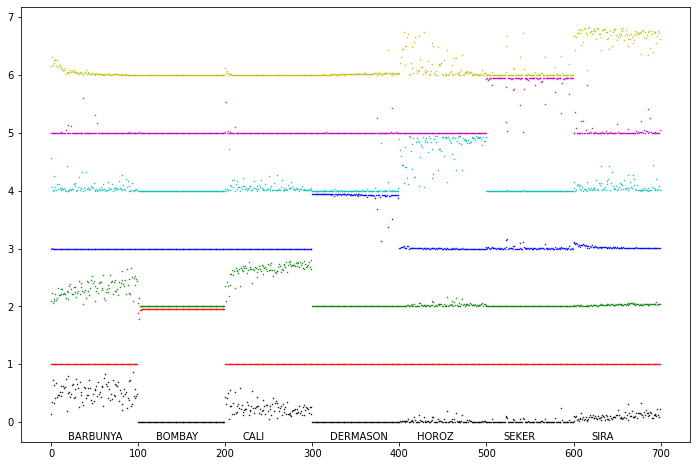

In [11]:
#yfit = ns.yfit
n = 0
plt.figure( 1, figsize=[12,8] )
col = ['k.','r.','g.','b.','c.','m.','y.'] 
for k in range( 7 ) :
    plt.plot( 0.95 * yfit[:,k] + k, col[k], markersize=1 )
    plt.text( npb * k + 20, -0.3, unik[k] )

plt.show()
